# NLP: Análisis de Sentimientos con VADER y RoBERTa
Análisis aplicado a descripciones de libros en español.

In [3]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
warnings.filterwarnings("ignore")

In [4]:
# Cargar datos
file_path = "../data/processed/books.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace(".", "_").str.replace(":", "")
df = df[["blurb", "tags", "book_title"]].dropna(subset=["blurb"]).head(500)
df.head()

,blurb,tags,book_title
0,"Walter Ciszek, jesuita norteamericano, entró e...","abandonment-in-god, biography, catholic, chełm...",Caminando por valles oscuros: Memorias de un j...
1,<p>A chance encounter with a reproduction of R...,"_pilar, _sindy, abandonment-in-god, anxiety, a...",The Return of the Prodigal Son: A Story of Hom...
2,"A pesar de nuestros mejores esfuerzos, muchos ...","catholic, chełmińska, christ, christianity, de...",Liberado: Una Guía Práctica para la Liberación
3,Esta breve obra se compone de cartas escritas ...,"abandonment-in-god, catholic, christ, classics...",El Abandono en la Divina Providencia: Clásicos...
4,Resulta difícil no emocionarse varias veces al...,"adventures, atheism, biography, catholic, chur...",Una familia de bandidos en 1793


## Preprocesamiento NLP: Tokenización con NLTK

In [5]:
import nltk
from nltk.tokenize import PunktSentenceTokenizer, TreebankWordTokenizer
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("vader_lexicon")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
tokenizer_sent = PunktSentenceTokenizer()
tokenizer_words = TreebankWordTokenizer()
example = df["blurb"].iloc[65]
sentences = tokenizer_sent.tokenize(example)
tokens = []
for sentence in sentences:
    tokens.extend(tokenizer_words.tokenize(sentence))
print(tokens)
print(nltk.pos_tag(tokens))

['St', 'John', 'of', 'the', 'Cross', 'testifies', 'to', 'a', 'God', 'who', 'longs', 'to', 'meet', 'us', 'in', 'our', 'deepest', 'need', '.', 'Whilst', 'rejection', 'and', 'imprisonment', 'played', 'their', 'part', 'in', 'the', 'life', 'of', 'this', 'sixteenth-century', 'Spanish', 'friar', ',', 'John', "'s", 'poetry', 'and', 'prose', 'reveal', 'the', 'beauty', 'and', 'power', 'of', 'a', 'wondrous', 'God', '.', 'It', 'gives', 'us', 'courage', 'to', 'believe', 'in', 'the', 'possibility', 'of', 'change', 'in', 'our', 'own', 'lives', ',', 'however', 'unlikely', 'or', 'impossible', 'this', 'may', 'seem.', '<', 'br', '/', '>', 'Father', 'Iain', 'Matthew', 'uses', 'this', 'classic', 'inspirational', 'Christian', 'writing', 'as', 'his', 'starting', 'point', ',', 'and', 'offers', 'five', 'interpretations', 'which', 'make', 'its', 'richness', 'relevant', 'to', 'the', 'modern', 'reader', '.']
[('St', 'NNP'), ('John', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('Cross', 'NNP'), ('testifies', 'NNS'), ('to

## Análisis de Sentimientos con VADER

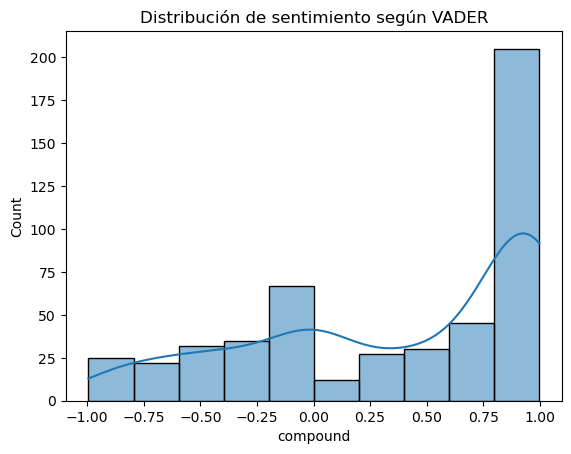

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
pol_scores = {}
for i, row in df.iterrows():
    text = row["blurb"]
    scores = sia.polarity_scores(text)
    pol_scores[i] = scores
vaders = pd.DataFrame(pol_scores).T
vaders = pd.concat([df.reset_index(drop=True), vaders.reset_index(drop=True)], axis=1)
sns.histplot(vaders["compound"], kde=True)
plt.title("Distribución de sentimiento según VADER")
plt.show()

## Análisis de Sentimientos con RoBERTa (inglés)

In [8]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
MODEL = "j-hartmann/emotion-english-distilroberta-base"
classifier = pipeline("text-classification", model=MODEL, return_all_scores=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Device set to use cpu


In [9]:
def mooder(text):
    max_len = 512
    encoded = tokenizer(text, return_tensors="pt", max_length=max_len, truncation=True, padding="max_length")
    with torch.no_grad():
        output = model(**encoded)
    scores = output.logits[0].numpy()
    return {
        "anger": scores[0], "disgust": scores[1], "fear": scores[2],
        "joy": scores[3], "neutral": scores[4], "sadness": scores[5],
        "surprise": scores[6]
    }

In [10]:
roberta = df["blurb"].apply(mooder)
roberta_df = pd.DataFrame(roberta.tolist())
moods = pd.concat([df.reset_index(drop=True), roberta_df.reset_index(drop=True)], axis=1)
moods.sample(10)

,blurb,tags,book_title,anger,disgust,fear,joy,neutral,sadness,surprise
221,<p>Cada jovencita sueña con ser rescatada por ...,"christianity, devotional, emotional-relationsh...",Cautivante: Revelando el misterio del alma de ...,0.199513,0.042624,-0.309042,-0.354101,2.456108,-0.232831,-1.120896
215,"In recent years, Christians everywhere are red...","004-ladder-long-term, catholic, christ, church...",Jesus and the Jewish Roots of the Eucharist: U...,-0.915839,-0.945621,-0.076716,0.437947,3.294345,-1.239650,0.490066
129,"Anjali Kumar, a pragmatic lawyer for Google, w...","america, angels, meditations, memoir, mountain...",Stalking God: My Unorthodox Search for Somethi...,-0.665678,-0.626159,0.993148,1.310431,0.844356,0.822065,-1.882799
395,"Beauty can be consoling, disturbing, sacred, p...","architecture, art, art-history, beauty, nonfic...",Beauty: A Very Short Introduction,-1.607599,0.149523,0.920209,2.337609,1.343358,-0.801228,-1.439134
64,A través de situaciones concretas de la vida c...,"abandonment-in-god, catholic, discernment, emo...",La paz interior,0.167100,0.458476,0.427231,-1.759012,2.112573,-0.390188,-1.355888
454,"When it comes to the history of Christianity, ...","catholic, christianity, church-history, patris...",The Early Church Was the Catholic Church : The...,-0.051076,-0.213631,-1.197114,-1.027931,4.392115,-1.630468,0.458038
380,"“Para unos era una monja laica, una matrona si...","america, award-winning, christ, lent, literatu...",Desolacion,0.677548,0.285913,-0.209435,-0.213064,1.744499,-0.561435,-0.677510
112,"<p>Este ebook presenta ""El idiota"", con un ind...","004-ladder-long-term, 19th-century, catholic, ...",El idiota,-0.361210,-0.212673,-1.041673,-0.171160,3.233150,-0.504978,-0.473447
455,The most nostalgic and reflective of Evelyn Wa...,"004-ladder-long-term, classics, fiction, liter...",Retorno a Brideshead (Andanzas),-2.355322,-1.271113,-2.211659,1.787904,2.457961,2.431296,-0.638167
149,Cardinal Carlo Martini is well-known for his a...,"catholic, church-history, devotional, gospels,...",The Gospel Way of Mary: A Journey of Trust and...,-1.950512,-0.435745,0.131544,-0.215570,3.572803,-0.257329,-0.738944


In [11]:
moods.sort_values(by="joy", ascending=False).head(10)

,blurb,tags,book_title,anger,disgust,fear,joy,neutral,sadness,surprise
5,This classic work by the great French poet and...,"005-ladder-maybe-someday, apostles, catholic, ...",I Believe in God: A Meditation on the Apostles...,-1.827595,-0.734062,-1.770854,5.021754,0.954775,-1.040457,0.530122
70,Elizabeth loves to hear her grandmother's stor...,"_natalia, biography, catholic, charity, childr...",Roses in the Snow: A Tale of Saint Elizabeth o...,-1.412908,-0.638500,-2.082694,4.989389,1.553652,-0.542219,-0.566234
461,Bookworms rejoice! These charming comics captu...,"books, comics, humor, illustrated, nonfiction,...",Book Love,-0.445919,-1.131097,-2.078908,4.805955,1.847271,-1.431224,0.063669
490,<div><b>A New York Times Notable Book: “A melo...,"animals, biography, entomology, gardening, nat...",A Book of Bees,-1.670138,-0.643183,-1.387707,4.140772,1.485223,0.030258,-0.628947
334,<p>This revised and expanded edition of <em>Th...,"classics, islamism, love, medieval, philosophy...",The Essential Rumi,-1.269807,-1.028930,-2.058158,4.080934,1.583242,-0.596333,0.227623
18,The way to perfection is simple—to unite one’s...,"001-ladder-top, abandonment-in-god, acceptance...",Uniformity with God's Will,-0.809839,0.083435,-2.425567,4.011043,2.309726,-0.342690,-1.849073
376,"Alexandre Havard, a Frenchman of Russian ances...","biography, france, illustrated, miex, orthodox...",My Russian Way: a spiritual autobiography,-1.514613,-0.713191,-2.273876,4.006494,2.487503,-0.349311,-0.884119
340,"<p>In <i>There Is a God</i>, one of the world'...","atheism, christianity, conversions, god-exists...",There Is a God: How the World's Most Notorious...,-1.079195,-1.244062,-1.911782,3.980678,2.529226,-1.167719,0.167120
81,<i>Land of the Firebird</i> is a WONDERFUL and...,"art, art-history, beauty, communism, empires, ...",Land of the Firebird: The Beauty of Old Russia,-0.793946,-1.161001,-2.230438,3.971892,1.634411,0.510954,-0.596902
442,"A collection of letters by Francois Fenelon, w...","catholic, marriage, religion, restart, spiritu...",Let Go,-0.709208,-0.478442,-1.979075,3.920964,2.398577,-1.688645,-0.247216


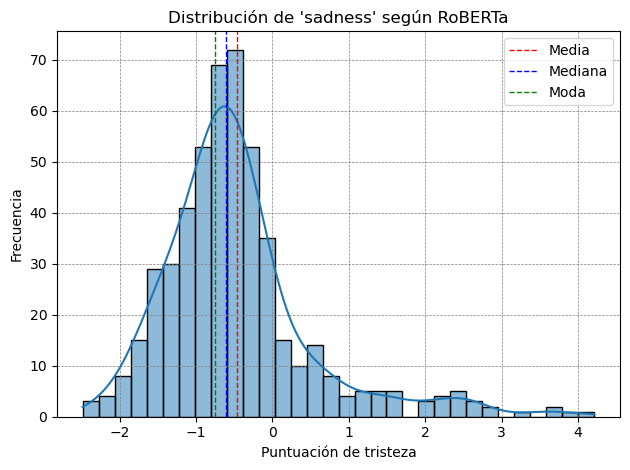

In [15]:
sns.histplot(moods["sadness"], kde=True)
plt.title("Distribución de 'sadness' según RoBERTa")
# Grid
plt.grid(visible=True, color="gray", linestyle="--", linewidth=0.5)
plt.axvline(moods["sadness"].mean(), color="red", linestyle="--", linewidth=1, label="Media")
plt.axvline(moods["sadness"].median(), color="blue", linestyle="--", linewidth=1, label="Mediana")
plt.axvline(moods["sadness"].mode()[0], color="green", linestyle="--", linewidth=1, label="Moda")
plt.legend()
plt.xlabel("Puntuación de tristeza")
plt.ylabel("Frecuencia")
plt.title("Distribución de 'sadness' según RoBERTa")
plt.tight_layout()
plt.grid(visible=True, color="gray", linestyle="--", linewidth=0.5)
# Guardar en imagen jpg
plt.savefig("../img/roberta-sadness.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [16]:
# Guardar el modelo y el tokenizer
joblib.dump(model, "../model/sentiment_roberta_model.joblib")
joblib.dump(tokenizer, "../model/sentiment_roberta_tokenizer.joblib")

['../model/sentiment_roberta_tokenizer.joblib']